## Settings...

In [2]:
from subprocess import call
from urllib import urlretrieve
import os
import gzip
import binascii
import ipywidgets
import struct
import numpy
import sys
import tensorflow
from matplotlib import pyplot
from ipywidgets import widgets


%matplotlib inline

save_dir = '/tmp/mnist'

download_base_url = 'http://yann.lecun.com/exdb/mnist/'

filenames = [
    'train-images-idx3-ubyte.gz', #:  training set images (9912422 bytes) 
    'train-labels-idx1-ubyte.gz', #:  training set labels (28881 bytes) 
    't10k-images-idx3-ubyte.gz',  #:   test set images (1648877 bytes) 
    't10k-labels-idx1-ubyte.gz'   #:   test set labels (4542 bytes)
]


## Grab the MNist files...

In [5]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for f in filenames:
    fullpath = os.path.join(save_dir, f)
    downloadurl = download_base_url + f
    print "Path", fullpath
    if os.path.exists(fullpath):
        print "Nothing to do."
    else:
        print "Downloading", downloadurl, "..."
        urlretrieve(downloadurl, fullpath)
        print "... done"

Path /tmp/mnist/train-images-idx3-ubyte.gz
Nothing to do.
Path /tmp/mnist/train-labels-idx1-ubyte.gz
Nothing to do.
Path /tmp/mnist/t10k-images-idx3-ubyte.gz
Nothing to do.
Path /tmp/mnist/t10k-labels-idx1-ubyte.gz
Nothing to do.


## Load data file and parse

In [6]:
def progress_dot():
    sys.stdout.write('.')
    sys.stdout.flush()

def unpack_int(data_file):
    data = data_file.read(4)
    data = struct.unpack('>i', data)[0]
    return data

def unpack_image(data_file):
    img = data_file.read(28 * 28)
    img = struct.unpack('B' * (28 * 28), img)
    img = numpy.array(img)
    img = (img - 128) / 255.0
    return img

def unpack_image_data(filename):
    print "Unpacking image", filename, "..."
    with gzip.open(os.path.join(save_dir, filename)) as data_file:
        fields = {
            'magic_number': unpack_int(data_file),
            'count': unpack_int(data_file),
            'rows': unpack_int(data_file),
            'columns': unpack_int(data_file),
        }
        image_count = fields['count']
        image_list = []
        if fields['magic_number'] != 2051:
            raise RuntimeError("Expected 2051 in first two bytes of file.")
        print "Reading", image_count, "images:"
        while(image_count > len(image_list)):
            if(len(image_list) % 1000 == 0):
                progress_dot()
            img = unpack_image(data_file)
            image_list.append(img)
        print "done"
        return fields, image_list

def unpack_labels(filename):
    print "Unpacking labels", filename, "..."
    with gzip.open(os.path.join(save_dir, filename)) as data_file:
        fields = {
            'magic_number': unpack_int(data_file),
            'count': unpack_int(data_file)
        }
        if fields['magic_number'] != 2049:
            raise RuntimeError("Expected 2049 in first two bytes of file.")
        print "Reading", fields['count'], 'labels:'
        label_data = data_file.read(fields['count'])
        label_list = struct.unpack('B' * fields['count'], label_data)
    print "... done"
    return fields, label_list

image_fields, image_list = unpack_image_data('train-images-idx3-ubyte.gz')
label_fields, label_list = unpack_labels('train-labels-idx1-ubyte.gz')
training = {
    'image_fields': image_fields,
    'image': image_list,
    'label_fields': label_fields,
    'label': label_list
}

image_fields, image_list = unpack_image_data('t10k-images-idx3-ubyte.gz')
label_fields, label_list = unpack_labels('t10k-labels-idx1-ubyte.gz')
testing = {
    'image_fields': image_fields,
    'image': image_list,
    'label_fields': label_fields,
    'label': label_list
}


Unpacking image train-images-idx3-ubyte.gz ...
Reading 60000 images:
............................................................done
Unpacking labels train-labels-idx1-ubyte.gz ...
Reading 60000 labels:
... done
Unpacking image t10k-images-idx3-ubyte.gz ...
Reading 10000 images:
..........done
Unpacking labels t10k-labels-idx1-ubyte.gz ...
Reading 10000 labels:
... done


## Show the images:

In [7]:
def pyplot_images(image_list):
    plot_count = len(image_list)
    _, plots = pyplot.subplots(1, plot_count)
    for i in range(plot_count):
        img = image_list[i]
        plot = plots[i]
        plot.imshow(img.reshape(28, 28), cmap=pyplot.cm.Greys)
            

Sample of First 3 from Training Set 60000 images:


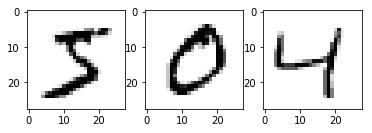

In [10]:
print "Sample of First 3 from Training Set", training['image_fields']['count'], "images:"
pyplot_images([training['image'][0], training['image'][1], training['image'][2]])

Sample of First 3 from Testing Set 10000 images:


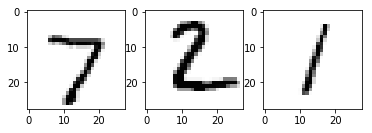

In [11]:
print "Sample of First 3 from Testing Set", testing['image_fields']['count'], "images:"
pyplot_images([testing['image'][0], testing['image'][1], testing['image'][2]])

## The Labels:  

In [12]:
def pyplot_hist(hist_data_list):
  plot_count = len(hist_data_list)
  _, plots = pyplot.subplots(1, plot_count)
  for i in range(plot_count):
        hist_data = hist_data_list[i]
        plot = plots[i]
        plot.hist(hist_data, bins=10, range=[0,10])

Sample Training Labels: (5, 0, 4) ...
Sample Testing Labels: (7, 2, 1) ...


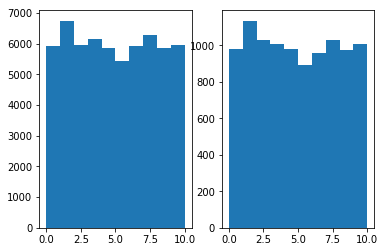

In [13]:
print "Sample Training Labels:", training['label'][0:3], '...'
print "Sample Testing Labels:", testing['label'][0:3], '...'
pyplot_hist([training['label'], testing['label']])

## Training...

In [17]:
def one_hot_vector(v):
    vec = [0.0] * 10
    vec[v] = 1.0
    return vec

def next_train_batch(i, n):
    batch_labels = training['label'][i : i + n]
    label_vec_list = []
    for label in batch_labels:
        label_vec = one_hot_vector(label)
        label_vec_list.append(label_vec)
    return training['image'][i : i + n], label_vec_list

# next_train_batch(0, 10)

In [18]:
sess = tensorflow.Session()


def training_from_tutorial(sess):
    input_count = 28 * 28
    output_count = 10
    batch_size = 100
    learning_rate = 0.5

    x = tensorflow.placeholder(tensorflow.float32, [None, input_count])
    w = tensorflow.Variable(tensorflow.zeros([input_count, output_count]))
    b = tensorflow.Variable(tensorflow.zeros([output_count]))
    y = tensorflow.nn.softmax(tensorflow.matmul(x, w) + b)
    y_ = tensorflow.placeholder(tensorflow.float32, [None, output_count])
    cross_entropy = tensorflow.reduce_mean(-tensorflow.reduce_sum(y_ * tensorflow.log(y), reduction_indices=[1]))
    train_step = tensorflow.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    init = tensorflow.global_variables_initializer()
    sess.run(init)

    print "Training"
    for i in range(0, len(training['label']), batch_size):
        batch_xs, batch_ys = next_train_batch(i, batch_size)
        progress_dot()
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    return (x, y, w, b, y_)

(x, y, w, b, y_) = training_from_tutorial(sess)


Training
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Labeled: 6


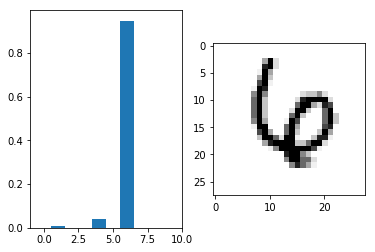

In [21]:
i = 22
test = numpy.array([testing['image'][i]])
output = sess.run(y, feed_dict={x: test})
_, plots = pyplot.subplots(1, 2)
plots[0].bar(range(0, 10), output[0], width=1.0)
plots[1].imshow(test.reshape(28, 28), cmap=pyplot.cm.Greys)
print "Labeled:", testing['label'][i]

## Validation and Testing

In [22]:
def one_hot_decode(a):
    return a.argmax()

hits = 0
misses = 0
for i in range(0, len(testing['label'])):
    img = testing['image'][i]
    expected_label = testing['label'][i]
    output = sess.run(y, feed_dict={x: [img]})
    output_label = one_hot_decode(output)
    if(expected_label == output_label):
        hits += 1
    else:
        misses += 1
        

In [23]:
(hits, misses, float(hits) * 100.0 / (hits + misses))

(8683, 1317, 86.83)

## Input

In [24]:
def score_js_data(imgOutput):
    img = (imgOutput - 128) / -255.0
    output = sess.run(y, feed_dict={x: [img]})
    _, plots = pyplot.subplots(1, 2)
    plots[0].bar(range(0, 10), output[0], width=1.0)
    plots[1].imshow(img.reshape(28, 28), cmap=pyplot.cm.Greys)

In [27]:
%%javascript

var canvas, ctx, div, clearButton, scoreButton;
var scaleMultiplier = 4;
var width = 28;
var height = 28;

function clearCanvas(){
    ctx.fillStyle = '#FFFFEE';
    ctx.fillRect(0, 0, width, height);
}

function putPixel(x, y){
    ctx.fillStyle = '#111111';
    ctx.fillRect(x, y, 2, 2);
}

function handleDraw(event){
    if(event.which == 1){
        putPixel(event.offsetX, event.offsetY);
    }
}

function imageRawData(){
  return ctx.getImageData(0, 0, width, height);
}

function imageData(){
    var imgData = imageRawData();
    console.log('data', imgData);
    var outputLength = imgData.width * imgData.height;
    var output = new Uint8ClampedArray(outputLength);
    var i, j, data, greyscaleValue;
    for(i = 0; i < outputLength; i++){
        j = i * 4;
        data = imgData.data;
        greyscaleValue = (data[j + 0] + data[j + 1] + data[j + 2]) / 3
        output[i] = parseInt(greyscaleValue);
    }
    return output;
}

canvas = $('<canvas width="' + width + '" height="' + height +
           '" style="transform: scale(' + scaleMultiplier + ',' + scaleMultiplier + '); ' +
           'position: relative; left: ' + (width + 20) + 'px; top: ' + (height + 20) + 'px;">')[0];
clearButton = $('<button style="position: relative; float: right;">Clear</button>');
scoreButton = $('<button style="position: relative; float: right;">Score</button>');
div = $('<div style="height: 160px; width: 400px;">')
div.append(canvas);
div.append(clearButton);
div.append(scoreButton);
$(element).append(div);
ctx = canvas.getContext("2d");
clearCanvas();

function notebookExec(command){
    console.log("Executing Command: " + command);
    var handle_output = function(val){
        console.log('handle_output', val);
    }
    var callbacks = {'output' : handle_output};
    var kernel = IPython.notebook.kernel;
    return kernel.execute(command, callbacks, {silent:false});
}

function scoreIt(){
    var var_name = 'imgOutput';
    var var_value = imageData();
    var set_command = var_name + " = numpy.array([" + var_value.join(',') + "])";
    var ret = notebookExec(set_command);
    console.log('ret', ret);
    ret = notebookExec('score_js_data(imgOutput)')
    console.log('ret', ret);
}

var drawTimeout = null;

function setDrawTimeout(){
    var delay = 800;
    var fn = function(){
        console.log('fn');
        scoreIt();
        clearCanvas();
        drawTimeout = null;
    }
    console.log('setting to');
    if(drawTimeout){
//         window.clearTimeout(drawTimeout);
    }
//     drawTimeout = window.setTimeout(fn, delay);
}

function handleDrawAndScore(e){
    handleDraw(e);
    setDrawTimeout();
}

$(canvas).click(handleDrawAndScore).mousemove(handleDrawAndScore);
$(clearButton).click(clearCanvas);
$(scoreButton).click(scoreIt);


<IPython.core.display.Javascript object>

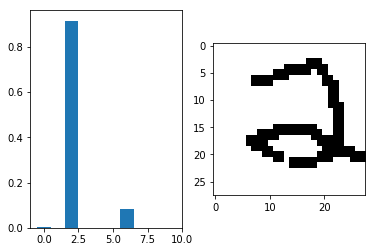

In [29]:
img = (imgOutput - 128) / -255.0
output = sess.run(y, feed_dict={x: [img]})

_, plots = pyplot.subplots(1, 2)
plots[0].bar(range(0, 10), output[0], width=1.0)
plots[1].imshow(img.reshape(28, 28), cmap=pyplot.cm.Greys)


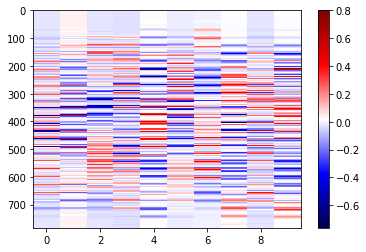

In [30]:
w_data = sess.run(w)
pyplot.imshow(w_data, cmap="seismic", aspect="auto")
pyplot.colorbar()

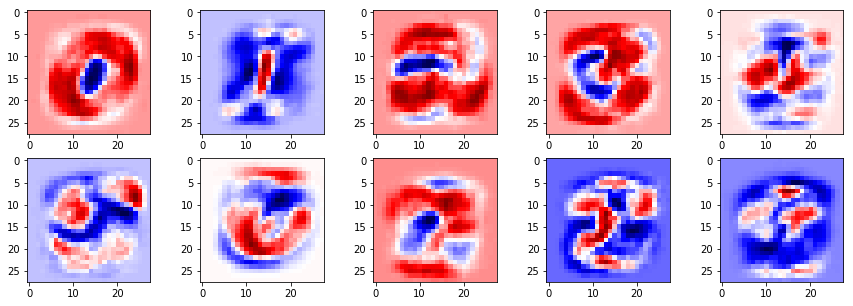

In [31]:
def output_plot(i, plot):
    w_data_for_output = []
    for data_part in w_data:
        w_data_for_output.append(data_part[i])
    len(w_data_for_output)
    a = numpy.array(w_data_for_output).reshape(28, 28)
    plot.imshow(a, cmap="seismic", aspect="equal")

_, plots = pyplot.subplots(2, 5, figsize=(15,5))
for i in range(10):
    output_plot(i, plots[i / 5][i % 5])
